In [1]:
import tensorflow as tf
from tensorflow.keras import layers
import os
import requests
import io
import PIL
import PIL.Image
import math
import pathlib
import numpy as np

In [2]:
batch_size = 8 # 每⼀批所处理的图⽚数量
img_height = 256 # 图⽚⾼度，单位为像素
img_width = 256 # 图⽚宽度，单位为像素

TF_SERVING_BASE_URL = 'http://localhost:8501/'
image_dir = './datasets/flower_photos'

task_id = '350002'
task_dir = os.path.join('./datasets/', task_id)
train_dir = os.path.join(task_dir, 'train')
test_dir = os.path.join(task_dir, 'test')

In [3]:
import shutil

id_code_mapping = { # 根据web界⾯显示情况设定
'daisy' : '0',
'dandelion' : '1', 
'roses' : '2', 
'sunflowers' : '3', 
'tulips' : '4', 
}
total_image_count = len(list(pathlib.Path(image_dir).glob('*/*.jpg')))
print(total_image_count)
print(train_dir)

for img in pathlib.Path(image_dir).glob('*/*.jpg'): 
    if np.random.ranf() < 0.8: # 需要通过修改数值来控制测试集的⽐例
      dst_dir = os.path.join(train_dir, os.path.basename(os.path.dirname(img)))
    else:
      dst_dir = os.path.join(test_dir, os.path.basename(os.path.dirname(img)))
    if not os.path.exists(dst_dir):
      os.makedirs(dst_dir)
    #print(os.path.dirname(img))
    dst = os.path.join(dst_dir, img.name)
    #print(dst)
    #dst = os.path.join(dst_dir, record['id']+'.png')
    #img.save(dst)
    shutil.copy(img, dst)

3670
./datasets/350002/train


In [4]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
train_dir,
validation_split=0.2, # 设定验证集⽐例
subset="training",
seed=123,
#image_size=(img_height, img_width),
batch_size=batch_size)

Found 3670 files belonging to 5 classes.
Using 2936 files for training.


In [5]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
train_dir,
validation_split=0.2, # 设定验证集⽐例
subset="validation",
seed=123,
#image_size=(img_height, img_width),
batch_size=batch_size)

Found 3670 files belonging to 5 classes.
Using 734 files for validation.


In [6]:
print(train_ds.class_names)
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

['daisy', 'dandelion', 'roses', 'sunflowers', 'tulips']
(8, 256, 256, 3)
(8,)


In [7]:
augmentation_dict = {
    'RandomFlip': tf.keras.layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
    'RandomRotation': tf.keras.layers.experimental.preprocessing.RandomRotation(0.2),
    'RandomContrast': tf.keras.layers.experimental.preprocessing.RandomContrast(0.2),
    'RandomZoom': tf.keras.layers.experimental.preprocessing.RandomZoom(height_factor=0.1, width_factor=0.1),
    'RandomTranslation': tf.keras.layers.experimental.preprocessing.RandomTranslation(height_factor=0.1, width_factor=0.1),
    'RandomCrop': tf.keras.layers.experimental.preprocessing.RandomCrop(img_height, img_width),

}

In [8]:
num_classes = 5

preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input
base_model = tf.keras.applications.MobileNetV2(input_shape=(img_height,img_width,3),
                                               include_top=False,
                                               weights='imagenet')
base_model.trainable = False

data_augmentation = tf.keras.Sequential([
    augmentation_dict['RandomTranslation'],
])

inputs = tf.keras.Input(shape=(img_height,img_width,3))
x = data_augmentation(inputs)
x = preprocess_input(x)
x = base_model(x, training=False)
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = tf.keras.layers.Dropout(0.2)(x)
outputs = tf.keras.layers.Dense(num_classes)(x)
model = tf.keras.Model(inputs, outputs)
print(model.summary())

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 256, 256, 3)]     0         
_________________________________________________________________
sequential (Sequential)      (None, 256, 256, 3)       0         
_________________________________________________________________
tf.math.truediv (TFOpLambda) (None, 256, 256, 3)       0         
_________________________________________________________________
tf.math.subtract (TFOpLambda (None, 256, 256, 3)       0         
_________________________________________________________________
mobilenetv2_1.00_224 (Functi (None, 8, 8, 1280)        2257984   
_________________________________________________________________
global_average_pooling2d (Gl (None, 1280)              0         
_________________________________________________________________
dropout (Dropout)            (None, 1280)              0     

In [9]:
model.compile(
optimizer='adam',
loss=tf.losses.SparseCategoricalCrossentropy(from_logits=True),
metrics=['accuracy'])

In [10]:
model.fit(
train_ds,
validation_data=val_ds,
epochs=3
)

Epoch 1/3
367/367 [==============================] - 88s 234ms/step - loss: 0.6639 - accuracy: 0.7568 - val_loss: 0.3678 - val_accuracy: 0.8815
Epoch 2/3
367/367 [==============================] - 87s 238ms/step - loss: 0.3659 - accuracy: 0.8730 - val_loss: 0.3146 - val_accuracy: 0.8951
Epoch 3/3
367/367 [==============================] - 87s 236ms/step - loss: 0.3052 - accuracy: 0.8924 - val_loss: 0.2947 - val_accuracy: 0.8992


In [11]:
tf.keras.models.save_model(
model,
'./models/image/1/', # ./models为tensorflow-serving的模型根⽬录
overwrite=True,
include_optimizer=True,
save_format=None,
signatures=None,
options=None
)

INFO:tensorflow:Assets written to: ./models/image/1/assets


/Users/sunxiaohua/opt/anaconda3/lib/python3.8/site-packages/keras/utils/generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


In [14]:
import numpy as np
import json
import matplotlib.pyplot as plt
def test_image_model(test_dir,  code, batch_size=10): 
  imgs = []
  codes = []
  imgdir = os.path.join(test_dir, val_ds.class_names[code]) 
  print(imgdir)
  right = 0
  wrong = 0
  for i in pathlib.Path(imgdir).glob('./*.jpg'): 
    #print(i.name)
    imgs = []
    img = PIL.Image.open(i)
    pixels = np.array(img)
    plt.imshow(pixels)
    imgs.append(pixels.tolist()) 
    img.close()
    for j in range(int(math.ceil(len(imgs)/batch_size))):
      req_data = json.dumps({
        'inputs': imgs[j*batch_size:(j+1)*batch_size],
      })
    
    #data = json.dumps({"signature_name": "serving_default", "instances": test_images[0:3].tolist()})
    #http://localhost:8501/v1/models/fashion_mnist:predict
    #print(TF_SERVING_BASE_URL+'v1/models/image/versions/1:predict')
    #response = requests.post(TF_SERVING_BASE_URL+'v1/models/image/versions/1:predict', # 根据部署地址填写
    #json_response = requests.post('http://localhost:8501/v1/models/fashion_mnist:predict', data=data, headers=headers)
    response = requests.post(TF_SERVING_BASE_URL+'v1/models/image:predict', # 根据部署地址填写
    data=req_data,
    headers={"content-type": "application/json"})
    #print(response.status_code)
    if response.status_code != 200:
      raise RuntimeError('Request tf-serving failed: ' + response.text)
    resp_data = json.loads(response.text) 
    if 'outputs' not in resp_data \
         or type(resp_data['outputs']) is not list:
      raise ValueError('Malformed tf-serving response')
    #print(np.argmax(resp_data['outputs']))
    if( int(np.argmax(resp_data['outputs']) == int(code) )):
       right = right + 1
    else:
       wrong = wrong + 1
    #codes.extend(np.argmax(resp_data['outputs'], axis=1).tolist())
    #print("class:"+ str(np.argmax(resp_data['outputs'])))
  return right/(right+wrong)

./datasets/350002/test/daisy
类别0的准确率 0.9156908665105387
./datasets/350002/test/dandelion
类别1的准确率 0.9652892561983472


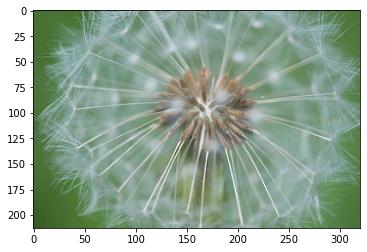

In [15]:
codes = test_image_model(test_dir,  0)
print('类别0的准确率', codes)
codes = test_image_model(test_dir, 1)
print('类别1的准确率', codes)